# SOCIAL BIAS INDICATOR

#### Pooja Kangokar Pranesh
#### DS 690: Introduction to Natural Language Processing

## Imports

In [ ]:
!pip install -qq pyLDAvis

     |████████████████████████████████| 1.7 MB 20.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import nltk
import pickle
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import re
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
porter = PorterStemmer()
import string

from textblob import TextBlob
from os import path
import nltk
nltk.download('punkt')
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Mounted at /content/gdrive


/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Data Read

In [ ]:
df = pd.read_csv("gdrive/My Drive/Colab Notebooks/SBIC.v2.agg.trn.csv")
df.head()

,Unnamed: 0,post,targetMinority,targetCategory,targetStereotype,whoTarget,intentYN,sexYN,offensiveYN,dataSource,hasBiasedImplication
0,0,"\n\nBill Kristol and Ben Shaprio, two turds in...",[],[],[],0.0,0.886667,0.0,1.000000,Gab,1
1,1,\n\nRose\n🌹Taylor‏ @RealRoseTaylor 6h6 hours a...,[],[],[],NaN,0.220000,0.0,0.000000,Gab,1
2,2,\nCharlie Kirk‏\n\nJohnny Depp calls for death...,"[""liberals""]","[""social""]","[""miscontrue things"", ""take things in a weird ...",1.0,1.000000,0.0,1.000000,Gab,0
3,3,\nDavid Knight‏ \n\nNotice how quickly things ...,[],[],[],0.0,0.110000,0.0,0.166667,Gab,1
4,4,\nFinland fireball: Time-lapse video shows nig...,[],[],[],NaN,0.000000,0.0,0.000000,Gab,1


## Pre-Processing

#### Check for null values

In [ ]:
df['post'].isnull().sum()

0

In [ ]:
# remove punctations
df['p']=df['post'].str.replace('"', '')
df['p'] = df['p'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
df['p'] = df['p'].apply(lambda elem: re.sub(r"\d+", "", elem))

#### Clean, Remove Stop Words, Punctuations, lemmatize

In [ ]:
def preprocess_txt(data):

  data = word_tokenize(data) # create tokens
  data = [x.lower() for x in data] # lowercase letters
  data = [re.sub('[0-9]+', '', x) for x in data] # remove numbers
  data = [porter.stem(word) for word in data] # stemming
  data = [w for w in data if not w in STOP_WORDS] # remove stop words
  data = list(filter(lambda token: token not in (str.maketrans('', '', string.punctuation)), data)) # remove punctutations
  data = [x for x in data if len(x) > 1] # len > 1
  data = [x for x in data if ' ' not in x] # no space
  
  return data

In [ ]:
df['clean_post'] = df['p'].apply(preprocess_txt)

In [ ]:
df.head(20)

,Unnamed: 0,post,targetMinority,targetCategory,targetStereotype,whoTarget,intentYN,sexYN,offensiveYN,dataSource,hasBiasedImplication,p,clean_post
0,0,"\n\nBill Kristol and Ben Shaprio, two turds in...",[],[],[],0.0,0.886667,0.000000,1.000000,Gab,1,Bill Kristol and Ben Shaprio two turds in the ...,"[bill, kristol, ben, shaprio, turd, toilet, bowl]"
1,1,\n\nRose\n🌹Taylor‏ @RealRoseTaylor 6h6 hours a...,[],[],[],NaN,0.220000,0.000000,0.000000,Gab,1,RoseTaylor h hours agoNewt nails it Say what ...,"[rosetaylor, hour, agonewt, nail, style, cant,..."
2,2,\nCharlie Kirk‏\n\nJohnny Depp calls for death...,"[""liberals""]","[""social""]","[""miscontrue things"", ""take things in a weird ...",1.0,1.000000,0.000000,1.000000,Gab,0,Charlie KirkJohnny Depp calls for death of Tru...,"[charli, kirkjohnni, depp, death, trump, left,..."
3,3,\nDavid Knight‏ \n\nNotice how quickly things ...,[],[],[],0.0,0.110000,0.000000,0.166667,Gab,1,David Knight Notice how quickly things turned ...,"[david, knight, notic, quickli, thing, turn, b..."
4,4,\nFinland fireball: Time-lapse video shows nig...,[],[],[],NaN,0.000000,0.000000,0.000000,Gab,1,Finland fireball Timelapse video shows night t...,"[finland, firebal, timelaps, video, night, tur..."
5,5,\nICE\n\n“Today’s actions send a strong messag...,[],[],[],NaN,0.000000,0.000000,0.000000,Gab,1,ICETodays actions send a strong message to US ...,"[icetoday, action, send, strong, messag, busi,..."
6,6,"\nIf family ""A"" went on a 2 month vacation,\na...",[],[],[],0.0,0.443333,0.000000,0.333333,Gab,1,If family A went on a month vacationand famil...,"[famili, went, month, vacationand, famili, hou..."
7,7,\nIsaiah 26:3\nYou will keep in perfect peace ...,[],[],[],NaN,0.000000,0.000000,0.000000,Gab,1,Isaiah You will keep in perfect peace those wh...,"[isaiah, perfect, peac, mind, steadfast, becau..."
8,8,\nJust watched facial recognition technology f...,"[""middle eastern folks"", ""muslim folks"", ""musl...","[""culture""]","[""middle eastern folks are terrorists"", ""middl...",1.0,1.000000,0.000000,1.000000,Gab,0,Just watched facial recognition technology fro...,"[watch, facial, recognit, technolog, china, pe..."
9,9,\nMany serial killers and all-around psychopat...,[],[],[],0.0,0.440000,0.000000,0.500000,Gab,1,Many serial killers and allaround psychopaths ...,"[mani, serial, killer, allaround, psychopath, ..."


## EDA

#### Sentiment polarity check with TextBlob

When a sentence is passed into Textblob it gives two outputs, which are polarity and subjectivity. Polarity is the output that lies between [-1,1], where -1 refers to negative sentiment and +1 refers to positive sentiment. This is used to check data distribution 

In [ ]:
df['lemma_clean_str'] = [' '.join(map(str,l)) for l in df['clean_post']]
df['sentiment'] = df['lemma_clean_str'].apply(lambda x: TextBlob(x).sentiment.polarity)

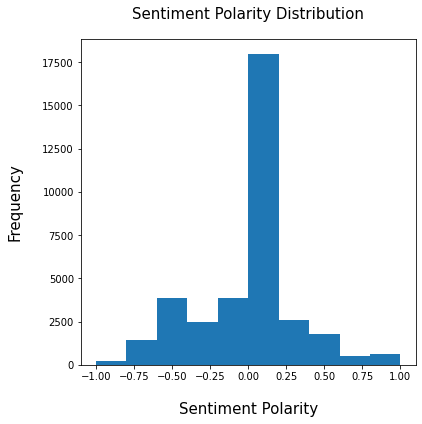

In [ ]:
plt.figure(figsize=(6,6))
plt.margins(0.05)
plt.xlabel('Sentiment Polarity', fontsize =15, labelpad=20)
plt.ylabel('Frequency', fontsize =15, labelpad=20)
plt.hist(df['sentiment'], bins=10)
plt.title('Sentiment Polarity Distribution', fontsize =15, pad=20)
plt.savefig('gdrive/My Drive/Colab Notebooks/1.png')
plt.show()


#### Findings_1: 

* Graph shows a combination of negatives, positives and neutral posts wherein most of them are netural and negatives

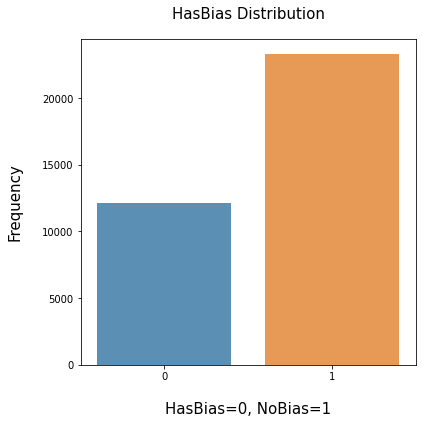

In [ ]:
plt.figure(figsize=(6,6))
x_bias = df.hasBiasedImplication.value_counts()
y_bias = x_bias.sort_index()
sns.barplot(x_bias.index, x_bias.values, alpha=0.8)
plt.title("HasBias Distribution", fontsize =15, pad=20)
plt.ylabel('Frequency', fontsize =15, labelpad=20)
plt.xlabel('HasBias=0, NoBias=1', fontsize =15, labelpad=20)
plt.show()

#### Findings_2:

* Graph Shows that there are almost ~12-13k posts are Offensive and has bias in them

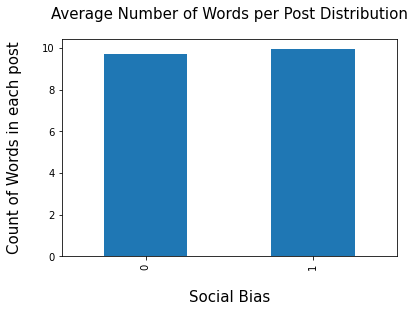

In [ ]:
# count the number of words in each post
df['words_cnt'] = df['lemma_clean_str'].apply(lambda x: len(str(x).split()))

word_avg = df.groupby('hasBiasedImplication')['words_cnt'].mean().plot(kind='bar')
plt.xlabel('Social Bias', fontsize =15, labelpad=20)
plt.ylabel('Count of Words in each post', fontsize =15, labelpad=20)
plt.title('Average Number of Words per Post Distribution', fontsize =15, pad=20)
plt.show()

#### Findings_3:

* Graph shows that most of post has 10-11 words

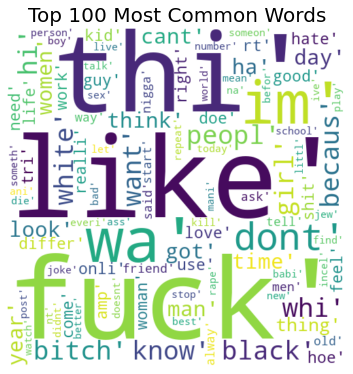

In [ ]:
import itertools

word = df['lemma_clean_str']
words = []
my_word_arr = []
a = []
for wordlist in word:
    my_word_arr.append(wordlist.split(' '))

for arr in my_word_arr:
  ab = itertools.chain(arr)
  a += ab

mostcmn = FreqDist(a).most_common(100)
wordcloud = WordCloud(width=500, height=500, background_color='white').generate(str(mostcmn))
fig = plt.figure(figsize=(5,5), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=20)
plt.tight_layout(pad=0)
plt.show()

#### Findings_4:

* Most used words are like, fuck, black, know, hate in our database

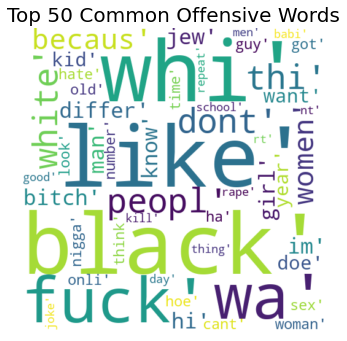

In [ ]:
Not_Offensive = df[df['offensiveYN'] == 0]
Offensive = df[df['offensiveYN'] == 1]

word = Offensive['lemma_clean_str']
words = []
my_word_arr = []
a = []
for wordlist in word:
    my_word_arr.append(wordlist.split(' '))

for arr in my_word_arr:
  ab = itertools.chain(arr)
  a += ab

mostcmn = FreqDist(a).most_common(50)
wordcloud = WordCloud(width=500, height=500, background_color='white').generate(str(mostcmn))
fig = plt.figure(figsize=(5,5), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Common Offensive Words', fontsize=20)
plt.tight_layout(pad=0)
plt.show()

#### Findings_5:

* Most common used offensive words are fuck, black, bitch, women, jew in our database

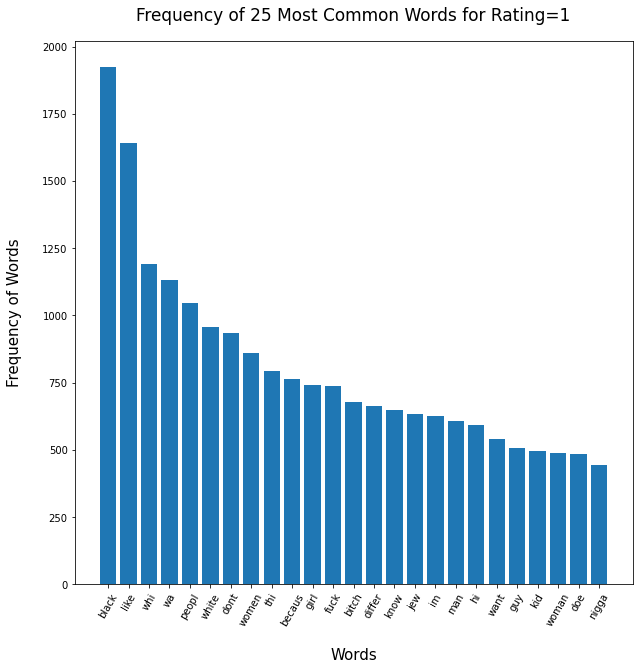

In [ ]:
group_by = df.groupby('hasBiasedImplication')['lemma_clean_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[0]

words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(10, 10))
plt.bar(words0, freq0)
plt.xlabel('Words',fontsize =15, labelpad=20)
plt.ylabel('Frequency of Words', fontsize =15, labelpad=20)
plt.xticks(rotation=60)
plt.title('Frequency of 25 Most Common Words for Rating=1', fontsize =17, pad=20)
plt.show()

#### Apply Word2Vec to see most similar words learning from Model

In [ ]:
model = Word2Vec(df['clean_post'], size=100, window=5, min_count=5, sg=1)

In [ ]:
pd.DataFrame(model.wv.most_similar('black'), columns=['Similar Words', 'Similarity'])

,Similar Words,Similarity
0,cop,0.860107
1,chain,0.842327
2,homeless,0.834973
3,color,0.827927
4,mexican,0.822515
5,hang,0.822454
6,indian,0.820421
7,cotton,0.820221
8,hispan,0.819918
9,kkk,0.819203


In [ ]:
def closestw_tsneplot(model, word):
    '''
     this class gets the word with the given pattern
     We put the vectors of the words closest to the word into an array
     With TSNE we convert these vectors to graphs.
    '''
    wc = np.empty((0,100)) # We have prepared a list of the closest ones
    word_labels = [word] # we made the word
    
    close_words = model.wv.most_similar(word) # words found near
    
    wc = np.append(wc, np.array([model.wv[word]]), axis=0) # added vector of incoming word
    
    for w, _ in close_words: #w is the word itself the other is the affinity ratio
        word_labels.append(w)
        wc = np.append(wc, np.array([model.wv[w]]), axis=0) # Added vectors of close words
        #so the incoming word and close words are word_labels, and their vectors are word_vectors.

    tsne = TSNE(random_state=0)
    Y = tsne.fit_transform(wc)
    
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    plt.scatter(x_coords, y_coords)
    
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(5, -2), textcoords='offset points')
        
    plt.show()

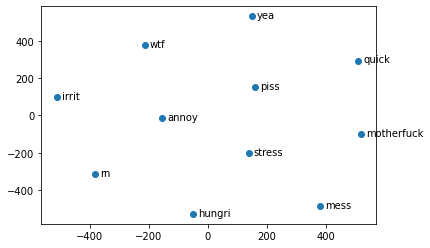

In [ ]:
closestw_tsneplot(model, 'piss')

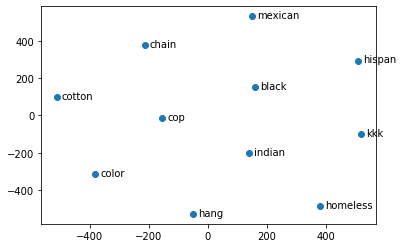

In [ ]:
closestw_tsneplot(model, 'black')

#### Install and pull required packages for transformers

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 5.8 MB 27.7 MB/s 
     |████████████████████████████████| 182 kB 77.7 MB/s 
     |████████████████████████████████| 7.6 MB 63.9 MB/s 


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# filtering the required columns
df_f = df[['post', 'hasBiasedImplication']]
df_o = df[['post', 'offensiveYN']]
df_c = df[['post', 'targetCategory']]

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

df_o.loc[df_o['offensiveYN'] >= 0.5, 'offensiveYN'] = 1
df_o.loc[df_o['offensiveYN'] < 0.5, 'offensiveYN'] = 0
df_o = df_o.astype({'offensiveYN': 'int32'})

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

#### DataRead

In [ ]:
class Dataset_c(torch.utils.data.Dataset):
    def __init__(self, df, labels_values, lable_column, data_column):
        if labels_values is None:
          self.labels = [label for label in df[lable_column]] # check
        else:
          self.labels = [labels_values[label] for label in df[lable_column]]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df[data_column]]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get batch labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get batch inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [ ]:
class SimpleGPT2SequenceClassifier(nn.Module):
    '''
    This class loads the GPT2 Pretrained Model
    '''
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    '''
    This function is used to train the dataset on train and validation sets against GPT2 Model
    '''
    train, val = train_data, val_data

    # Load Train and Validation Stes
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True) 
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    # Check cuda availability

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    # Set critertion and optimizer

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    # For each epoch do the following

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            # predict output
            output = model(input_id, mask)
            
            # check loss
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc
            
            # calculates grads
            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

In [ ]:
def evaluate(model, test_data):

    test = test_data

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # add predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels

#### Split the dataset

In [ ]:
# offensive or not
np.random.seed(112)
df_o_train, df_o_val, df_o_test = np.split(df_o.sample(frac=1, random_state=35), [int(0.8*len(df_o)), int(0.9*len(df_o))])

print(len(df_o_train), len(df_o_val), len(df_o_test))

categories = df_c['targetCategory'].unique()
labels_test = {}
for i, c in enumerate(categories):
  key, value = c, i
  labels_test[key] = value

# target category
df_c_train, df_c_val, df_c_test = np.split(df_c.sample(frac=1, random_state=35), [int(0.8*len(df_c)), int(0.9*len(df_c))])

print(len(df_c_train), len(df_c_val), len(df_c_test))



# bias or not
df_f_train, df_f_val, df_f_test = np.split(df_f.sample(frac=1, random_state=35), [int(0.8*len(df_f)), int(0.9*len(df_f))])

print(len(df_f_train), len(df_f_val), len(df_f_test))

28339 3542 3543
28339 3542 3543
28339 3542 3543


In [ ]:
df_o_train_1 = Dataset_c(df_o_train, None, 'offensiveYN', 'post')
df_o_val_1 = Dataset_c(df_o_val, None, 'offensiveYN', 'post')
df_o_test_1 = Dataset_c(df_o_test, None, 'offensiveYN', 'post')

df_c_train_1 = Dataset_c(df_c_train, labels_test, 'targetCategory', 'post')
df_c_val_1 = Dataset_c(df_c_val, labels_test, 'targetCategory', 'post')
df_c_test_1 = Dataset_c(df_c_test, labels_test, 'targetCategory', 'post')

df_f_train_1 = Dataset_c(df_f_train, None, 'hasBiasedImplication', 'post')
df_f_val_1 = Dataset_c(df_f_val, None, 'hasBiasedImplication', 'post')
df_f_test_1 = Dataset_c(df_f_test, None, 'hasBiasedImplication', 'post')

#### Train Offensive Classification Model

In [ ]:
EPOCHS = 1
model1 = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model1, df_o_train_1, df_o_val_1, LR, EPOCHS)

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

100%|██████████| 14170/14170 [23:06<00:00, 10.22it/s]


Epochs: 1 | Train Loss:  0.250             | Train Accuracy:  0.759             | Val Loss:  0.305             | Val Accuracy:  0.727


#### Train Category Classification Model

In [ ]:
EPOCHS = 1
model2 = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=50, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model2, df_c_train_1, df_c_val_1, LR, EPOCHS)

100%|██████████| 14170/14170 [23:32<00:00, 10.03it/s]


Epochs: 1 | Train Loss:  0.529             | Train Accuracy:  0.704             | Val Loss:  0.474             | Val Accuracy:  0.725


#### Train BiasImplication Classification Model

In [ ]:
EPOCHS = 1
model3 = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model3, df_f_train_1, df_f_val_1, LR, EPOCHS)

100%|██████████| 14170/14170 [23:01<00:00, 10.26it/s]


Epochs: 1 | Train Loss:  0.238             | Train Accuracy:  0.770             | Val Loss:  0.206             | Val Accuracy:  0.799


#### Evaluate the Offensive Classification Model

In [ ]:
true_labels_o, pred_labels_o = evaluate(model1, df_o_test_1)

Test Accuracy:  0.726


In [ ]:
true_labels_c, pred_labels_c = evaluate(model2, df_c_test_1)

Test Accuracy:  0.721


In [ ]:
true_labels_f, pred_labels_f = evaluate(model3, df_f_test_1)

Test Accuracy:  0.800


### Save the model

In [ ]:
model_save_name = 'Offensive.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/models/{model_save_name}" 
torch.save(model1.state_dict(), path)

model_save_name = 'Category.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/models/{model_save_name}" 
torch.save(model2.state_dict(), path)

model_save_name = 'BiasImplication.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/models/{model_save_name}" 
torch.save(model3.state_dict(), path)